In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [45]:
audio_file = "./14/19020066_HoangHuuTung/c1.wav"

In [46]:
ipd.Audio(audio_file,autoplay=True)

In [4]:
# load audio files with librosa
signal, sr = librosa.load(audio_file)

In [5]:
print(sr)

22050


In [6]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)

In [7]:
mfccs.shape

(13, 223)

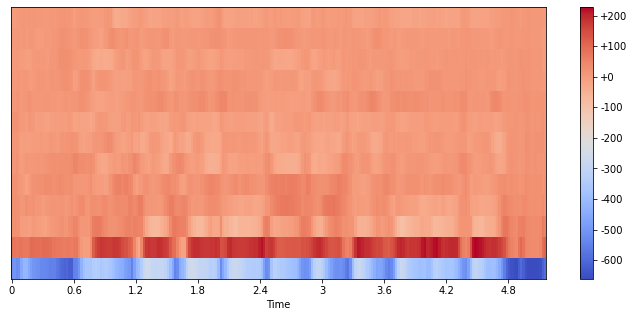

In [8]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [9]:
delta_mfccs = librosa.feature.delta(mfccs)

In [10]:
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [11]:
delta_mfccs.shape

(13, 223)

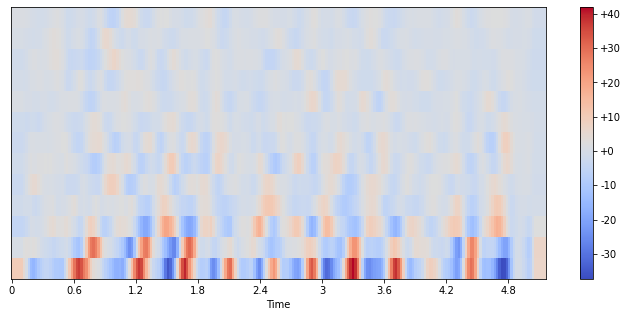

In [12]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

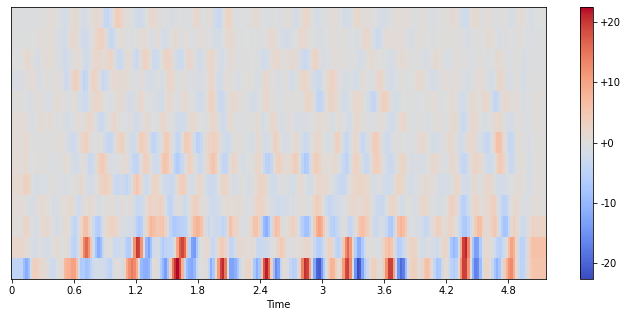

In [13]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [14]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [15]:
mfccs_features.shape

(39, 223)

In [16]:
class_names = ['xuong', 'len', 'phai', 'trai', 'nhay', 'ban', 'a', 'b', 'sil']

In [17]:
for i in class_names:
    !mkdir $i

A subdirectory or file xuong already exists.
A subdirectory or file len already exists.
A subdirectory or file phai already exists.
A subdirectory or file trai already exists.
A subdirectory or file nhay already exists.
A subdirectory or file ban already exists.
A subdirectory or file a already exists.
A subdirectory or file b already exists.
A subdirectory or file sil already exists.


In [18]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Hàm cắt file wav

In [19]:
input_path = './14/'
output_path = './'
from pydub import AudioSegment
def split_wav(t1,t2,name,dir_name,name_export):
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    name = input_path + dir_name +'/'+ name
    newAudio = AudioSegment.from_wav(name)
    newAudio = newAudio[t1:t2]
    name_export = output_path + name_export +".wav"
    newAudio.export(name_export, format="wav")

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Tiền xử lý dữ liệu
Dữ liệu đang ở dạng 1 file wav chứa rất nhiều từ, chúng ta cần tách file wav thành nhiều file nhỏ và mỗi file chỉ có 1 từ duy nhất 
Hàm này sẽ tách toàn bộ âm thanh chứa trong data, chia nó về các folder data train với tên folder là các nhãn, trong các folder này chứa nhiều file wav, mỗi file wav chỉ chứa duy nhất tiếng của nhãn cần train

In [20]:
count = 0
import os
import pandas as pd
for name_dir in os.listdir(os.path.join(input_path)):
    for i in os.listdir(os.path.join(input_path, name_dir)):
        if i.endswith('.wav'):
            path = i[:-3]
            path_txt = path + 'txt'
            if(os.path.exists(os.path.join(input_path,name_dir,path_txt))):
                df = pd.read_csv(os.path.join(input_path,name_dir,path_txt), sep="\t", header=None)
                for index, row in df.iterrows():
                    count+=1
                    isdir = os.path.isdir(path)
                    if(row[2]=='sli'):
                        row[2] = 'sil'
                    row[2]=row[2].replace(" ", "")
                    row[2]=row[2].lower()
                    if(row[2]=='pha'):
                        row[2] = 'phai'

                    if row[2]=='suong':
                        row[2] = 'xuong'
                    if row[2]=='xuon':
                        row[2] = 'xuong'
                    name_export = row[2] +'/'+ str(count)
                    split_wav(row[0],row[1],i,name_dir,name_export)
                

In [21]:
print(count)

4584


In [22]:
# import time
# for name_dir in os.listdir(os.path.join(output_path)):
#     if name_dir == 'sil' or name_dir =='__notebook_source__.ipynb':
#         continue
#     for i in os.listdir(os.path.join(output_path, name_dir)):
#         if i.endswith('.wav'):
#             ipd.display(ipd.Audio(os.path.join(output_path,name_dir,i),autoplay=True))
#             time.sleep(1)
    

In [23]:
# HMM state cho từng từ
states = [9, 9, 9, 9, 9, 9, 9, 9, 9]

In [24]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm

def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
#     hop_length = math.floor(sr*0.010) # 10ms hop
    hop_length = 256
#     win_length = math.floor(sr*0.025) # 25ms frame
    win_length = 512
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=13, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
#     mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    mfcc = np.subtract(mfcc,np.mean(mfcc))
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 39 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 39 (transpose of X)
    return X.T # hmmlearn use T x N matrix

In [25]:
a = get_mfcc('./14/19020066_HoangHuuTung/c15-c23.wav')
print(type(a.shape))

<class 'tuple'>


In [29]:
#clean file

all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join("./", cname, i) for i in os.listdir(os.path.join('./', cname)) if i.endswith('.wav')]
    data = []
    for file_path in file_paths:
        try:
            data.append(get_mfcc(file_path))
        except:
            print(file_path)
            os.remove(file_path) 
    
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]

In [33]:
from sklearn.model_selection import train_test_split

X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
for cname in class_names:
    x_train, x_test, _, y_test = train_test_split(
        all_data[cname], all_labels[cname], 
        test_size = 0.33, 
        random_state=42
    )
    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

In [34]:
for cname in class_names:
    print(cname,len(X['train'][cname]), len(X['test'][cname]), len(y['test'][cname]))

xuong 318 158 158
len 335 166 166
phai 306 152 152
trai 340 168 168
nhay 365 181 181
ban 317 157 157
a 326 161 161
b 361 179 179
sil 394 195 195


In [35]:
import hmmlearn.hmm as hmm

model = {}
for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0
    
    #trans matrix

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx], 
        verbose=True, 
        n_iter=300, 
        startprob_prior=start_prob, 
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='mc',
        random_state=42
    )

    model[cname].fit(X=np.vstack(X['train'][cname]), lengths=[x.shape[0] for x in X['train'][cname]])

         1    -1932703.4512             +nan
         2    -1850949.1608      +81754.2904
         3    -1840266.4321      +10682.7287
         4    -1836768.5985       +3497.8337
         5    -1834661.0061       +2107.5924
         6    -1832759.8546       +1901.1515
         7    -1830962.9086       +1796.9461
         8    -1829596.5380       +1366.3706
         9    -1828606.4805        +990.0575
        10    -1827112.6451       +1493.8353
        11    -1824413.2317       +2699.4134
        12    -1821828.1360       +2585.0957
        13    -1819881.7776       +1946.3584
        14    -1818636.6689       +1245.1087
        15    -1817711.0198        +925.6491
        16    -1817396.3819        +314.6380
        17    -1817287.8423        +108.5395
        18    -1817229.7442         +58.0981
        19    -1817201.7457         +27.9985
        20    -1817185.1371         +16.6086
        21    -1817172.4437         +12.6933
        22    -1817164.1346          +8.3091
        23

In [36]:
import pickle
!mkdir models_train
# save model
for cname in class_names:
    name = f'models_train/model_{cname}.pkl'
    with open(name, 'wb') as file: 
        pickle.dump(model[cname], file)

A subdirectory or file models_train already exists.


In [37]:
import pickle, os
import numpy as np

from sklearn.metrics import classification_report

In [38]:
y_true = []
y_pred = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    print((np.array(y_true) == np.array(y_pred)).sum()/len(y_true))
print(y_true)
print(y_pred)


1.0
0.9938271604938271
0.976890756302521
0.9782608695652174
0.9781818181818182
0.9796334012219959
0.9816272965879265
0.981089258698941
0.980883322346737
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [39]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       xuong       0.99      1.00      1.00       158
         len       0.99      0.99      0.99       166
        phai       0.95      0.94      0.95       152
        trai       0.94      0.98      0.96       168
        nhay       0.97      0.98      0.98       181
         ban       0.98      0.99      0.98       157
           a       0.99      0.99      0.99       161
           b       1.00      0.98      0.99       179
         sil       1.00      0.98      0.99       195

    accuracy                           0.98      1517
   macro avg       0.98      0.98      0.98      1517
weighted avg       0.98      0.98      0.98      1517



In [40]:
#loadmodels
import pickle

model_train = {}
for key in class_names:
    name = f"models_train/model_{key}.pkl"
    with open(name, 'rb') as file:
        model_train[key] = pickle.load(file)

In [41]:
print(model_train)

{'xuong': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]]),
            verbose=True), 'len': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.

In [42]:
!zip -r models.zip models_train

  adding: models_train/ (260 bytes security) (stored 0%)
  adding: models_train/model_a.pkl (172 bytes security) (deflated 20%)
  adding: models_train/model_b.pkl (172 bytes security) (deflated 22%)
  adding: models_train/model_ban.pkl (172 bytes security) (deflated 22%)
  adding: models_train/model_len.pkl (172 bytes security) (deflated 29%)
  adding: models_train/model_nhay.pkl (172 bytes security) (deflated 22%)
  adding: models_train/model_phai.pkl (172 bytes security) (deflated 25%)
  adding: models_train/model_sil.pkl (172 bytes security) (deflated 24%)
  adding: models_train/model_trai.pkl (172 bytes security) (deflated 25%)
  adding: models_train/model_xuong.pkl (172 bytes security) (deflated 26%)
